<a href="https://colab.research.google.com/github/sob-ANN/Deep-Learning-APL745-/blob/main/Deep_o_net_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:

import torch     
from torch import Tensor                  
import torch.nn as nn                 
import torch.optim as optim              
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

"""Function to convert numpy to torch with gradients"""

def npt(y):
    
    y = torch.tensor(y, requires_grad=True)
    return y




"""Load the training data from numpy"""

d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
y_train=d["X"][1].astype(np.float32) #output locations (100,1)
u_train = d["X"][0].astype(np.float32) # input functions (150,100)
s_train = d["y"].astype(np.float32) # output functions (150,100)

"""**Define Network Archietecture**"""

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        
        self.layers = layers
        layer = []
        
        for i in range(len(layers) - 1):
            layer.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer.append(nn.Tanh())
                
        self.layers = nn.Sequential(*layer)
        print(self.layers)
     
        
    def forward(self, x): #forward pass
        out = self.layers(x)
        return out




"""**The DeepONet Archietecture**"""

class PI_DeepONet():
    def __init__(self, branch_layers, trunk_layers,u_train, y_train, s_train):
        
        self.u_train = npt(u_train)       #convert to torch tensor
        self.y_train = npt(y_train)       #convert to torch tensor
        self.s_train = npt(s_train)
        
        self.branch_net = DNN(branch_layers).to(device)  # The branch Network

        self.trunk_net = DNN(trunk_layers).to(device)    # The trunk Network
        
        branch_params = list(self.branch_net.parameters())               #extract the network Parameters in list format
        trunk_params =  list(self.trunk_net.parameters())               #extract the network Parameters
        params = branch_params+trunk_params
        
        self.optimizer =torch.optim.LBFGS(params,) ######### 

        self.optimizer_Adam = torch.optim.Adam(params, lr=0.007)

        self.iter = 0    #initiate iteration

    
    def operator_net(self,  u, y):    # Define DeepONet architecture
        B = self.branch_net(u) #output from branch Network
        T = self.trunk_net(y)  #output from branch Network 

        output = torch.matmul(B, torch.transpose(T,0,1))
        
   
        return output
        
    # Define operator loss
    def loss_operator(self, u , y, s_train):

           
        pred = self.operator_net(u, y)         # Compute forward pass     
        loss = torch.mean((pred - s_train)**2)         # Compute loss
        return loss
        
    def loss_func(self):   #Define loss function for optimization step
        loss = self.loss_operator(self.u_train, self.y_train, self.s_train)
        self.optimizer.zero_grad()
        loss.backward()
        return loss
    
    def train(self, nIter):
        model_loss=np.array([])
        for epoch in range(nIter):
            loss= self.loss_operator(self.u_train,self.y_train, self.s_train)
            
             # Backward and optimize
           
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            model_loss=np.append(model_loss,loss.detach().numpy())   #get the loss value for each iteration

            if epoch % 25 == 0:
                print(epoch, model_loss[-1])
               # print loss and iteration
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
        return model_loss[-1] 
             
    # Evaluates predictions at test points  
    def predict_s(self, u_star,y_star):
        #####
        ####
        s = self.operator_net(u_star, y_star) #predict
        s = s.detach().cpu().numpy()
        return s

"""**Train the Model**"""

# Initialize model

branch_layers = [100, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]

model = PI_DeepONet(branch_layers, trunk_layers,u_train, y_train, s_train)


'Neural Network Summary'
print(model)
nIter=2000
loss=model.train(nIter)

"""**Load Test Data**"""

d = np.load("antiderivative_aligned_test.npz", allow_pickle=True) 
B=d["X"][0].astype(np.float32)
u_test = d["X"][0].astype(np.float32); y_test=d["X"][1].astype(np.float32)
s_test = d["y"].astype(np.float32)

u_test = npt(u_test)
y_test = npt(y_test)
s_test = npt(s_test)

u_train = npt(u_train)
y_train = npt(y_train)
s_train = npt(s_train)
#Model Predictions 
#Training Predictions


s_pred_train = model.predict_s(u_train, y_train)

#Testing predictions
s_pred = model.predict_s(u_test, y_test)



cpu
Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=50, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=50, bias=True)
)
0 0.33477291464805603
25 0.027178552001714706
50 0.034374967217445374
75 0.008169038221240044
100 0.011503884568810463
125 0.004835222382098436
150 0.005930834915488958
175 0.04198074713349342
200 0.0077778189443051815
225 0.004491647705435753
250 0.02590840868651867
275 0.04

**Training Predictions:**

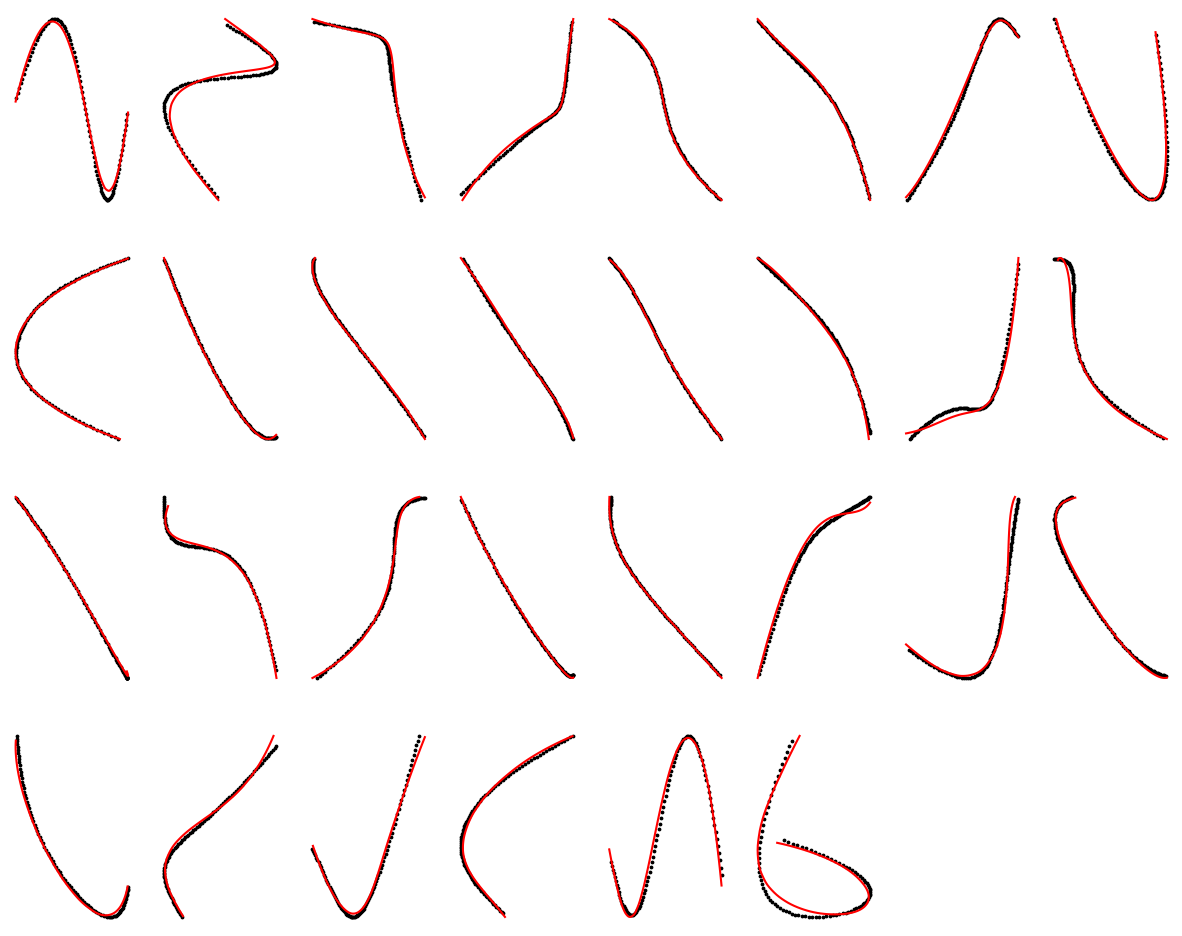

In [32]:
fig = plt.figure(figsize=(15,15))
for i in range(30):  
    
    
    ax = fig.add_subplot(5, 8, i+1)
    ax.scatter(s_pred_train[i], s_pred_train[i+1], s = 12, c = 'black', marker='.')  
    ax.plot(s_train[i].detach().numpy(), s_train[i+1].detach().numpy(), c='r')
    
    plt.axis('off')

**Testing Predictions**

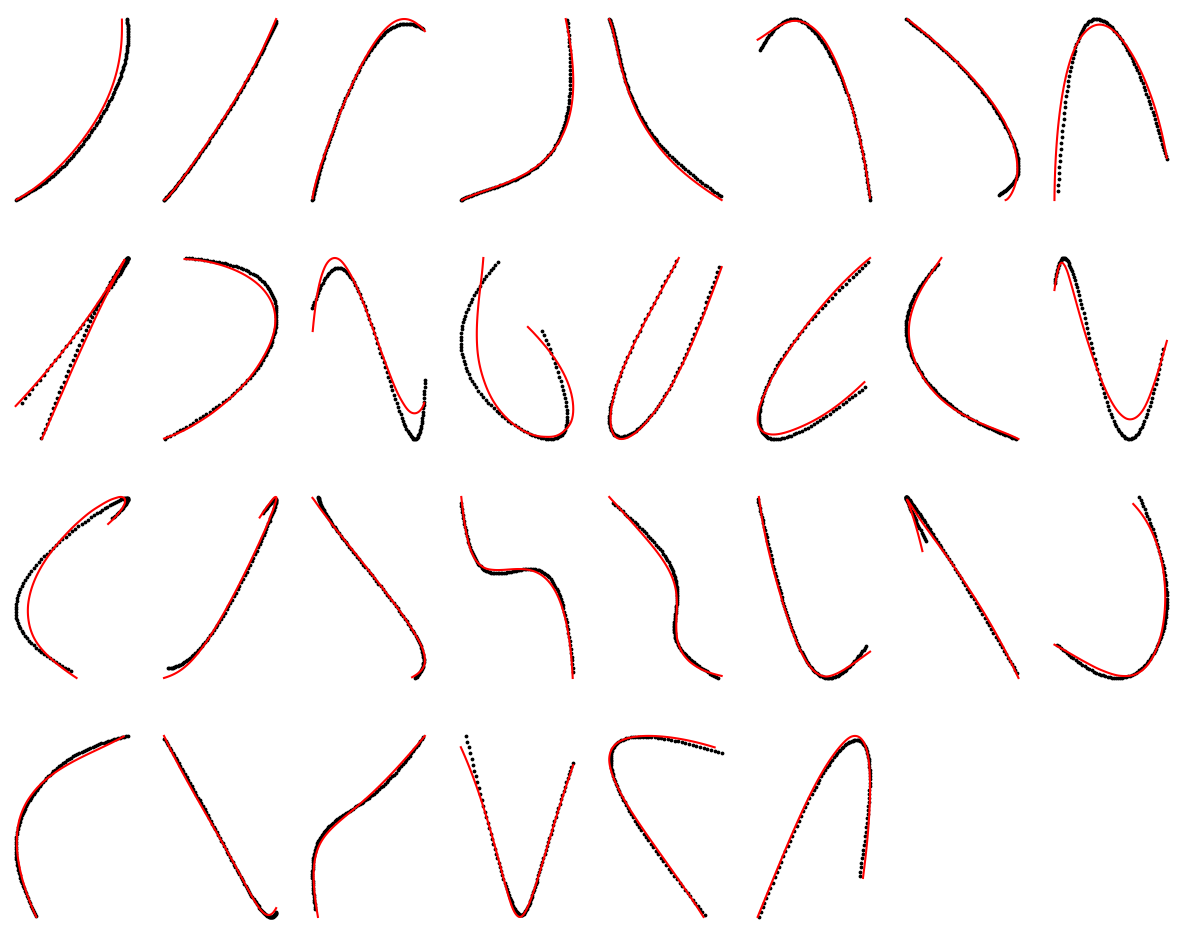

In [33]:
fig = plt.figure(figsize=(15,15))
for i in range(30):  
    
    
    ax = fig.add_subplot(5, 8, i+1)
    ax.scatter(s_pred[i], s_pred[i+1], s = 12, c = 'black', marker='.')  
    ax.plot(s_test[i].detach().numpy(), s_test[i+1].detach().numpy(), c='r')
    
    plt.axis('off')